In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from gradcam import make_gradcam_heatmap, create_gradcam_visualization
from utils import train_model
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))


I0000 00:00:1770896678.530811    3115 cpu_feature_guard.cc:227] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.22.0-dev20260211
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W0000 00:00:1770896687.996852    3115 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 45s 0us/step


In [3]:
base_model = keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

for layer in base_model.layers[::-1]:
    if 'conv' in layer.name or 'activation' in layer.name:
        last_conv_layer_name = layer.name
        break

print(f"Using layer: {last_conv_layer_name}")

W0000 00:00:1770896747.236457    3115 gpu_device.cc:2459] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1770896747.422047    3115 gpu_device.cc:2043] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9218 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:06:00.0, compute capability: 12.0a


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Using layer: top_activation


In [4]:
X_train_resized = np.array([keras.preprocessing.image.smart_resize(img, (224, 224)) for img in X_train[:5000]])
X_test_resized = np.array([keras.preprocessing.image.smart_resize(img, (224, 224)) for img in X_test[:1000]])

X_train_preprocessed = keras.applications.efficientnet_v2.preprocess_input(X_train_resized)
X_test_preprocessed = keras.applications.efficientnet_v2.preprocess_input(X_test_resized)

model, history = train_model(
    model, 
    X_train_preprocessed, 
    y_train[:5000],
    model_name='cifar10_efficientnet',
    epochs=10,
    early_stopping=False
)

W0000 00:00:1770896774.674696    3115 cpu_allocator_impl.cc:82] Allocation of 2408448000 exceeds 10% of free system memory.
W0000 00:00:1770896777.493935    3115 cpu_allocator_impl.cc:82] Allocation of 2408448000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1770896785.652631    3736 service.cc:153] XLA service 0x728e581728e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770896785.652668    3736 service.cc:161]   StreamExecutor [0]: NVIDIA GeForce RTX 5070, Compute Capability 12.0a (Driver: 13.1.0; Runtime: 12.8.0; Toolkit: 12.5.0; DNN: 9.10.2)
I0000 00:00:1770896785.850855    3736 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1770896787.275111    3736 cuda_dnn.cc:461] Loaded cuDNN version 91002
I0000 00:00:1770896787.704114    3736 dot_merger.cc:481] Merging Dots in computation: a_inference_one_step_on_data_83368__.266
E0000 00:00:1770896790.975894    3917 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1770896791.725955    3925 cuda_timer.cc:87] Delay kernel timed out: me

  1/125 ━━━━━━━━━━━━━━━━━━━━ 40:14 19s/step - accuracy: 0.0938 - loss: 2.3086

I0000 00:00:1770896798.875238    3736 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5815 - loss: 1.2755

W0000 00:00:1770896801.936580    3115 cpu_allocator_impl.cc:82] Allocation of 602112000 exceeds 10% of free system memory.
W0000 00:00:1770896802.683061    3115 cpu_allocator_impl.cc:82] Allocation of 602112000 exceeds 10% of free system memory.
I0000 00:00:1770896809.198732    4662 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_MatMul_4', 4 bytes spill stores, 4 bytes spill loads

E0000 00:00:1770896810.506166    4662 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1770896810.631596    4657 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1770896810.703827    4657 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup exec

125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - accuracy: 0.7168 - loss: 0.8718 - val_accuracy: 0.8560 - val_loss: 0.4151
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8400 - loss: 0.4749 - val_accuracy: 0.8620 - val_loss: 0.3858
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8705 - loss: 0.3870 - val_accuracy: 0.8930 - val_loss: 0.3474
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.8852 - loss: 0.3440 - val_accuracy: 0.8910 - val_loss: 0.3333
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8985 - loss: 0.3032 - val_accuracy: 0.8810 - val_loss: 0.3347
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9130 - loss: 0.2705 - val_accuracy: 0.8810 - val_loss: 0.3283
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9128 - loss: 0.2393 - val_accuracy: 0.8880 - val_loss: 0.3192
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9268 - loss: 0.2119 - val_accuracy: 0.8

E0000 00:00:1770896874.820483    5983 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1770896875.060707    5975 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1770896875.176526    5983 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1770896875.563656    5982 cuda_timer.cc:87] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
True: cat
Predicted: cat (0.9089)


/home/vscode/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


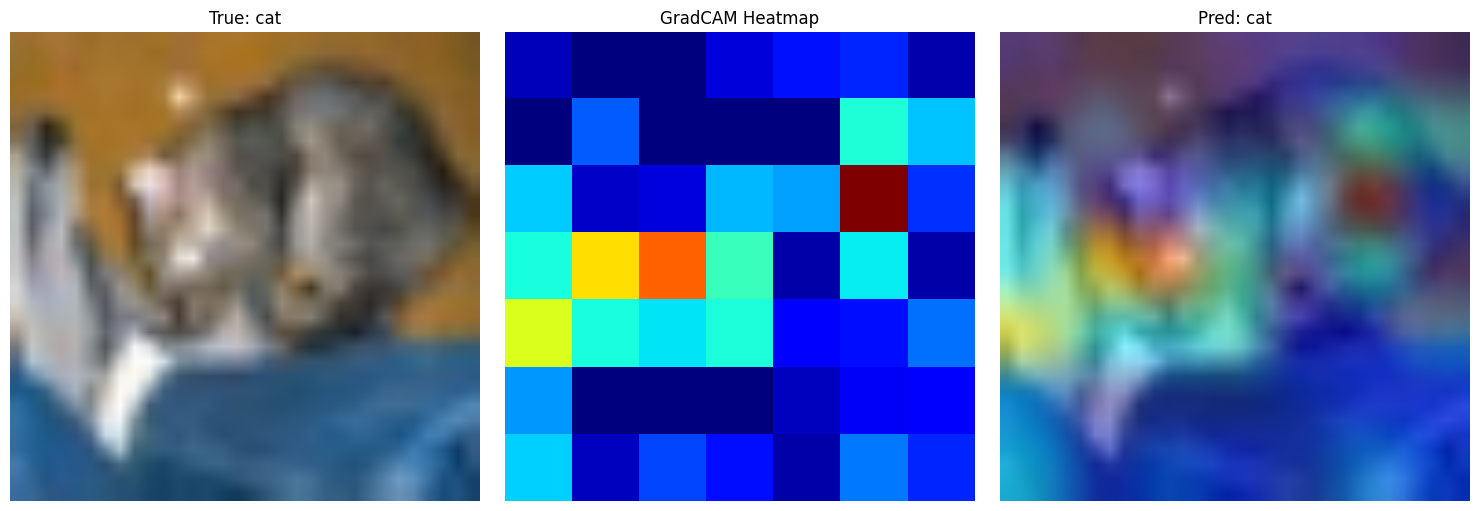

In [5]:
img_idx = 0
img_original = X_test[img_idx]
img = X_test_resized[img_idx]
img_preprocessed = X_test_preprocessed[img_idx]
true_label = y_test[img_idx]

img_array = np.expand_dims(img_preprocessed, axis=0)
preds = model.predict(img_array)
pred_label = np.argmax(preds[0])

print(f"True: {class_names[true_label]}")
print(f"Predicted: {class_names[pred_label]} ({preds[0][pred_label]:.4f})")

heatmap = make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img.astype('uint8'))
axes[0].set_title(f"True: {class_names[true_label]}")
axes[0].axis('off')

axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title("GradCAM Heatmap")
axes[1].axis('off')

superimposed = create_gradcam_visualization(img, heatmap)
axes[2].imshow(superimposed)
axes[2].set_title(f"Pred: {class_names[pred_label]}")
axes[2].axis('off')

plt.tight_layout()
plt.show()

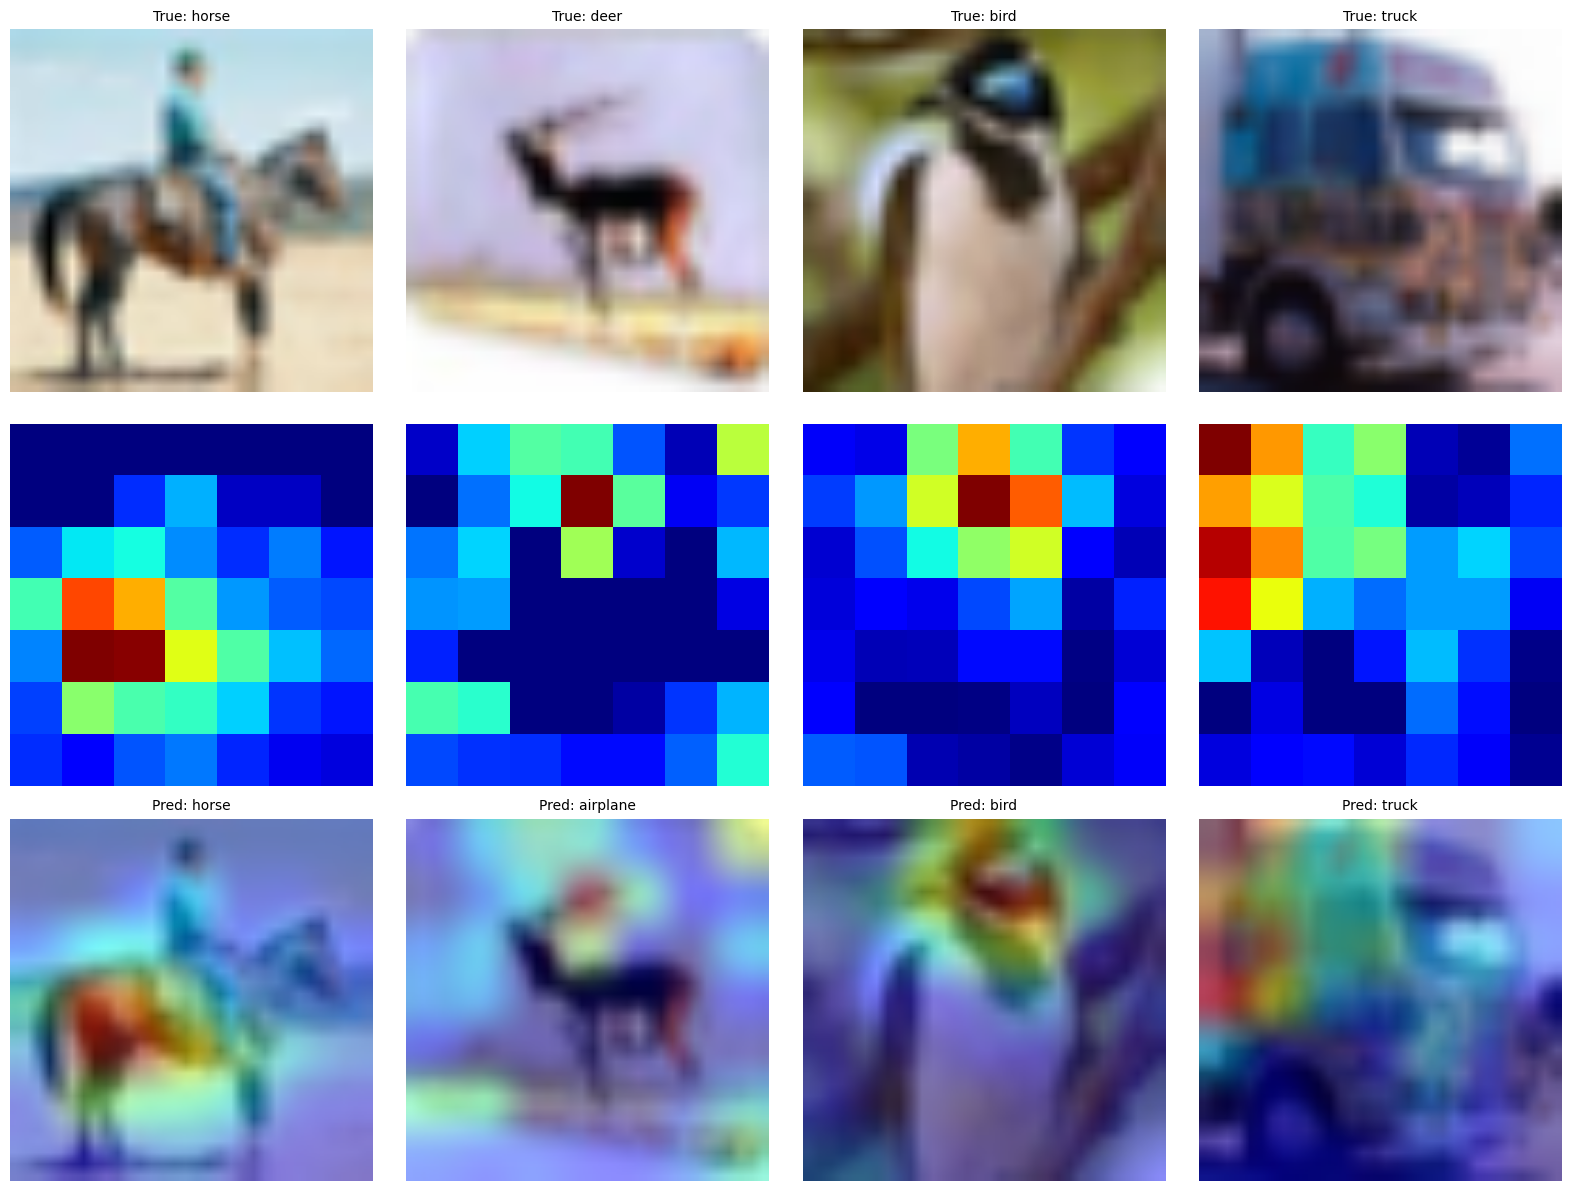

In [6]:
np.random.seed(42)
indices = np.random.choice(len(X_test_resized), 4, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for col, idx in enumerate(indices):
    img = X_test_resized[idx]
    img_preprocessed = X_test_preprocessed[idx]
    true_label = y_test[idx]
    
    img_array = np.expand_dims(img_preprocessed, axis=0)
    preds = model.predict(img_array, verbose=0)
    pred_label = np.argmax(preds[0])
    
    heatmap = make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name)
    superimposed = create_gradcam_visualization(img, heatmap)
    
    axes[0, col].imshow(img.astype('uint8'))
    axes[0, col].set_title(f"True: {class_names[true_label]}", fontsize=10)
    axes[0, col].axis('off')
    
    axes[1, col].imshow(heatmap, cmap='jet')
    axes[1, col].axis('off')
    
    axes[2, col].imshow(superimposed)
    axes[2, col].set_title(f"Pred: {class_names[pred_label]}", fontsize=10)
    axes[2, col].axis('off')

plt.tight_layout()
plt.show()